# Import mudules and data

In [1]:
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv, norm, det
from multiprocessing import Pool
import time

import sampler.dpp as dpp
import sampler.mcdpp as mcdpp
import sampler.utils as utils
import sampler.sadpp as sadpp
import sampler.greedy as greedy

In [2]:
lmbd = 1e-4
nTrn = 4000
nTot = 5000
data = pd.read_csv('data/ailerons.txt')[:nTot].values
trnY = data[:nTrn, -1]
tstY = data[nTrn:, -1]
pairwise_dists = squareform(pdist(data[:,:-1], 'euclidean'))
L_0 = np.exp(-pairwise_dists ** 2 / 100 ** 2)
trnL_0 = L_0[:nTrn, :nTrn]

# Full GP

In [3]:
sigma2_0 = nTrn*lmbd
inv_mat_0 = inv(trnL_0 + sigma2_0 * np.identity(nTrn))
alpha_0 = inv_mat_0 @ trnY

In [4]:
# correct the scaling factor
# Newton like method for optimization of hyperparameter
scale = trnY.var()/sigma2_0
for i in range(100):
    dscale = - nTrn/(2*scale) + 1/(2*scale**2) * trnY @ inv_mat_0 @ trnY
    ddscale = (nTrn/2*scale**2) - 1/(scale**3) * trnY @ inv_mat_0 @ trnY
    scale -= 0.1*dscale/ddscale

In [5]:
dscale/ddscale

3.0751594601313973e-10

In [6]:
sigma2 = scale * sigma2_0
L = scale * L_0
trnL = scale * trnL_0

In [7]:
inv_mat = inv(trnL + sigma2 * np.identity(nTrn))
alpha = inv_mat @ trnY
Y_hat_full = L[:,:nTrn]@ alpha
Var_Y_hat_full = L - L[:,:nTrn] @ inv_mat @ L[:nTrn,:]
error_full_trn = norm(Y_hat_full[:nTrn] - trnY)
error_full_tst = norm(Y_hat_full[nTrn:] - tstY)

# Nystrom GP

In [8]:
k_group = [20,30,50,70,100,150,200,250,300]

In [9]:
def compute_score(smpl):
    scores = np.zeros([10])
    k = len(smpl)
    C = trnL[np.ix_(range(nTrn), smpl)]
    W = C[np.ix_(smpl, range(k))]
    trnL_prime = C @ inv(W) @ C.T
    W_inv = inv(W)
    CC = C.T @ C
    A = CC @ W_inv
    B = inv(sigma2*W + CC)
    Y_hat = L[np.ix_(range(nTot), smpl)] @ W_inv @ (1/sigma2*(C.T @ trnY - CC @ B @ C.T @ trnY) )
    Var_Y_hat = L + \
                L[np.ix_(range(nTot), smpl)] @ (
                    - (1/sigma2*(W_inv @ A - A.T @ B @ A) )
                ) @ L[np.ix_(range(nTot), smpl)].T
    tmp = np.stack([
            Y_hat_full[nTrn:], np.diag(Var_Y_hat_full)[nTrn:] + sigma2, 
            Y_hat[nTrn:],      np.diag(Var_Y_hat)[nTrn:] + sigma2
        ]).T
    scores[0] += np.linalg.slogdet(W)[1]
    scores[1] += norm(trnL_prime - trnL, 'fro')
    scores[2] += norm(Y_hat[:nTrn] - trnY)
    scores[3] += norm(Y_hat[nTrn:] - tstY)
    scores[4] += np.apply_along_axis(arr=tmp,axis=1,func1d=utils.kl_gaussian_vec).mean()
    scores[5] += utils.kl_multi_gaussian(Y_hat, Var_Y_hat, Y_hat_full, Var_Y_hat_full)
    return scores

In [10]:
def simulate_once(i):
    
    np.random.seed(i)

    error_unif = np.zeros((10, len(k_group)))
    error_dpp = np.zeros((10, len(k_group)))
    error_mcdpp = np.zeros((10, len(k_group)))
    error_sadpp = np.zeros((10, len(k_group)))
    error_greedy = np.zeros((10, len(k_group)))

    for k_idx in range(len(k_group)):
        k = k_group[k_idx]

        # Uniform sampling
        start = time.time()
        unif_smpl = np.random.permutation(nTrn)[:k]
        end = time.time()
        error_unif[:,k_idx] += compute_score(unif_smpl)
        error_unif[9,k_idx] += end - start
        
        # DPP
        #D, V = utils.get_eig(trnL_0, flag_gpu=flag_gpu)
        #E = utils.get_sympoly(D, k, flag_gpu=flag_gpu)
        #dpp_smpl  = dpp.sample(D, V, E=E, k=k, flag_gpu=False)
        #error_dpp[:,k_idx] += compute_score(dpp_smpl)
        
        #MC-DPP
        #too slow to wait mixing
        start = time.time()
        mcdpp_smpl  = mcdpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=False, silent=True)
        end = time.time()
        error_mcdpp[:,k_idx] += compute_score(mcdpp_smpl)
        error_mcdpp[9,k_idx] += end - start
        
        #SA-DPP
        start = time.time()
        sadpp_smpl = sadpp.sample(trnL_0, mix_step=nTrn, k=k, flag_gpu=False, silent=True, func_beta=lambda i:1+np.log(1+i))
        end = time.time()
        error_sadpp[:,k_idx] += compute_score(sadpp_smpl)
        error_sadpp[9,k_idx] += end - start
        
        #greedy
        start = time.time()
        greedy_smpl  = greedy.sample(k, k//5, 100, trnL, trnY, nTrn, sigma2)
        end = time.time()
        error_greedy[:,k_idx] += compute_score(greedy_smpl)
        error_greedy[9,k_idx] += end - start
        
    return [error_unif, error_dpp, error_mcdpp, error_sadpp, error_greedy]

In [11]:
n_job = 6
with Pool(processes=6) as p:
    results = p.map(simulate_once, [i for i in range(n_job)])

In [12]:
error_unif = np.zeros((10, len(k_group)))
error_dpp = np.zeros((10, len(k_group)))
error_mcdpp = np.zeros((10, len(k_group)))
error_sadpp = np.zeros((10, len(k_group)))
error_greedy = np.zeros((10, len(k_group)))

for r in results:
    error_unif += r[0]
    error_dpp += r[1]
    error_mcdpp += r[2]
    error_sadpp += r[3]
    error_greedy += r[4]

# Plot

In [13]:
%matplotlib inline

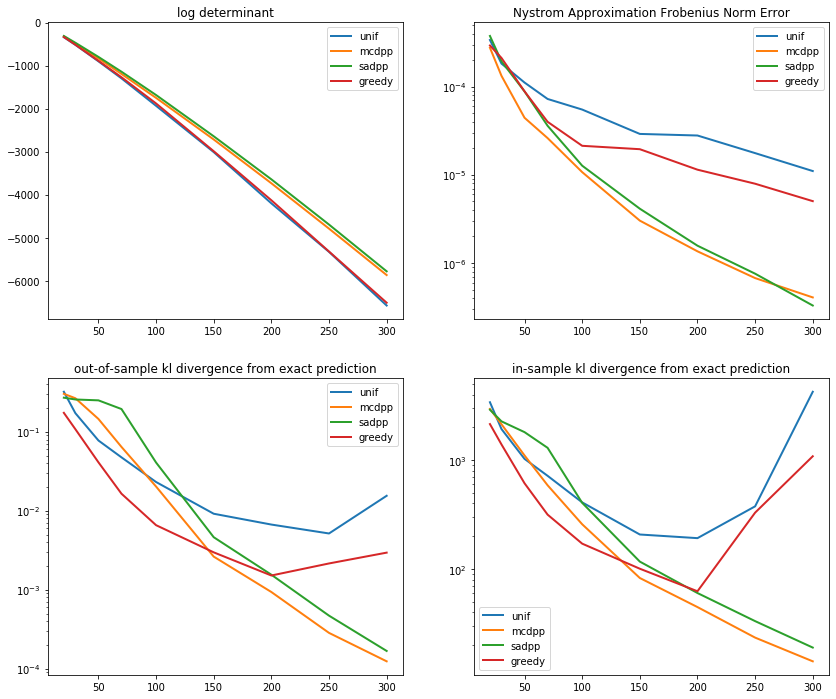

In [14]:
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
plt.title('log determinant')
plt.plot(k_group, error_unif[0] / n_job, label='unif', lw=2)
#plt.plot(k_group, error_dpp[0] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[0] / n_job, label='mcdpp', lw=2)
plt.plot(k_group, error_sadpp[0] / n_job, label='sadpp', lw=2)
plt.plot(k_group, error_greedy[0] / n_job, label='greedy', lw=2)
plt.legend()

plt.subplot(2,2,2)
plt.title('Nystrom Approximation Frobenius Norm Error')
plt.plot(k_group, error_unif[1], label='unif', lw=2)
#plt.plot(k_group, error_dpp[1], label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[1], label='mcdpp', lw=2)
plt.plot(k_group, error_sadpp[1], label='sadpp', lw=2)
plt.plot(k_group, error_greedy[1], label='greedy', lw=2)
plt.yscale('log')
plt.legend()
#plt.savefig('fig/nystrom', bbox_inches='tight')

plt.subplot(2,2,3)
plt.title('out-of-sample kl divergence from exact prediction')
plt.plot(k_group, error_unif[4] / n_job, label='unif', lw=2)
#plt.plot(k_group, error_dpp[4] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[4] / n_job, label='mcdpp', lw=2)
plt.plot(k_group, error_sadpp[4] / n_job, label='sadpp', lw=2)
plt.plot(k_group, error_greedy[4] / n_job, label='greedy', lw=2)
plt.yscale('log')
plt.legend()

plt.subplot(2,2,4)
plt.title('in-sample kl divergence from exact prediction')
plt.plot(k_group, error_unif[5] / n_job, label='unif', lw=2)
#plt.plot(k_group, error_dpp[5] / n_job, label='dpp', lw=2)
plt.plot(k_group, error_mcdpp[5] / n_job, label='mcdpp', lw=2)
plt.plot(k_group, error_sadpp[5] / n_job, label='sadpp', lw=2)
plt.plot(k_group, error_greedy[5] / n_job, label='greedy', lw=2)
plt.legend()
plt.yscale('log')
plt.legend()

plt.savefig('fig/summary', bbox_inches='tight')

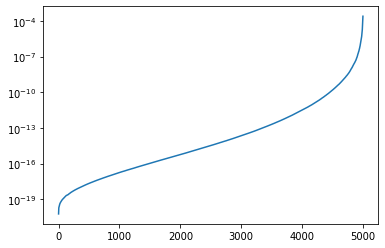

In [15]:
# distribution of eigen values
D, V = utils.get_eig(L, flag_gpu=False)
plt.plot(D)
plt.yscale('log')